<h3>Get Stock Data</h3>

In [4]:
from pandas_datareader.data import DataReader 
from datetime import date
import yfinance as yf


currencies = ["BTC-USD","ETH-USD","TTE.PA"] 
start_date = '2021-01-01'
end_date = str(date.today())

yf.pdr_override()
df = DataReader(
    'BTC-USD',
    # 'yahoo',
    start=start_date,
    end=end_date
)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


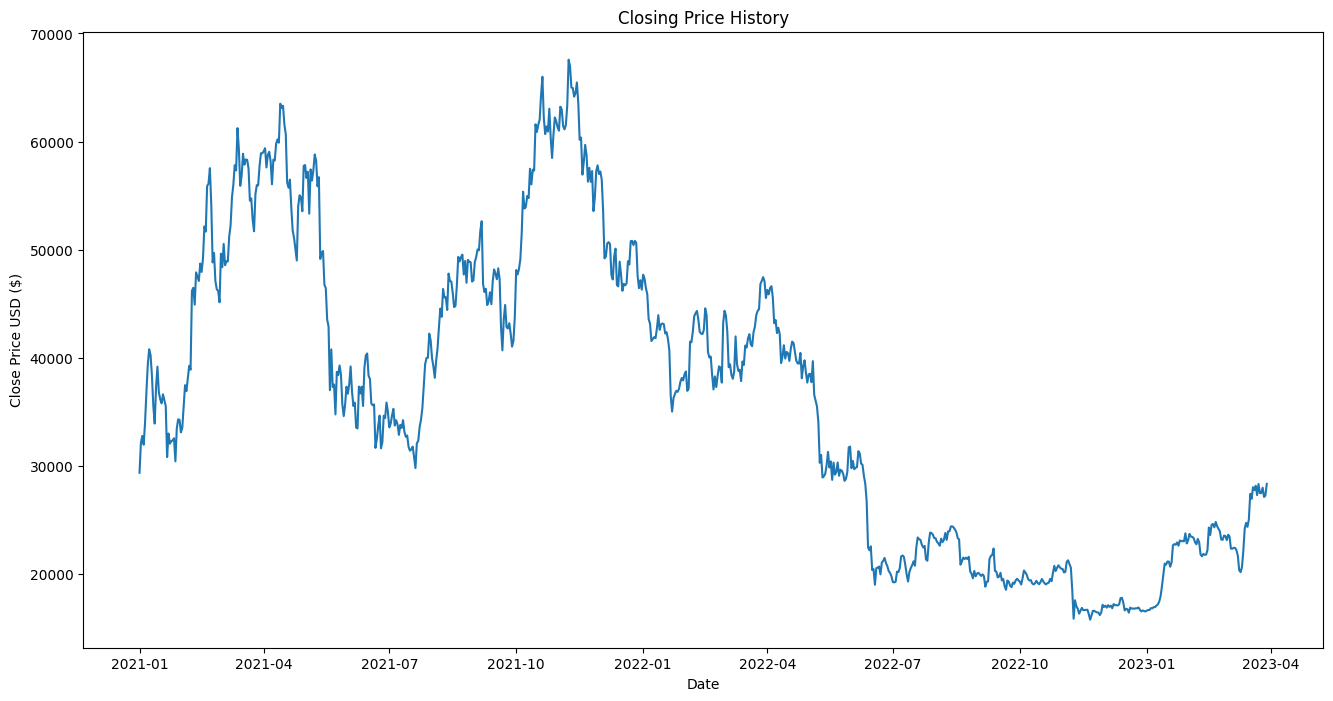

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.ylabel('Close Price USD ($)')
plt.xlabel('Date')
plt.title('Closing Price History')
plt.show()

In [6]:
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = df.filter(['Close']).values
training_data_len = math.ceil(0.8*len(data))

# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(data)

# train_data = scaled_data[:training_data_len]
# test_data = scaled_data[training_data_len:]

train_data = data[:training_data_len]
test_data = data[training_data_len:]

x_train , y_train = [] , []

# lag_len = 60
# for i in range(lag_len, len(train_data)):
#     x_train.append(train_data[i-60:i,0])
#     y_train.append(train_data[i,0])


# x_test , y_test = [] , []

# for i in range(lag_len, len(test_data)):
#     x_test.append(test_data[i-60:i,0])
#     y_test.append(test_data[i,0])

# x_train , y_train = np.array(x_train) , np.array(y_train)
# x_test , y_test = np.array(x_test) , np.array(y_test)

# x_train = np.reshape(x_train , (x_train.shape[0],x_train.shape[1],1))
# x_test = np.reshape(x_test , (x_test.shape[0],x_test.shape[1],1))

<h1>Neural Network</h1>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
# plt.style.use()

<h3>Hyperparameters and other variable definition</h3>

In [8]:
def create_dataset(dataset , lag :int):
    x , y = [] , []
    for i in range(lag, len(dataset)):
        x.append(dataset[i-lag:i,0])
        y.append(dataset[i,0])
    return torch.Tensor(x),torch.Tensor(y)

In [9]:
lag = 60
x_train , y_train = create_dataset(train_data,lag)
x_test , y_test = create_dataset(test_data,lag)

/tmp/ipykernel_6401/1287518317.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.Tensor(x),torch.Tensor(y)


In [10]:

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# Used to enable training analysis through TensorBoard
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

Using device: cuda

NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [11]:
class NaiveLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = x_train.shape[1],
            hidden_size = 10,
            num_layers = 1,
            batch_first=True
        )
        self.linear = nn.Linear(10,1)
    
    def forward(self,x):
        x,_ = self.lstm(x)
        x = self.linear(x)
        return x

In [19]:
import torch.utils.data as data
import torch.optim as optim 

from torch.utils.tensorboard import SummaryWriter

learning_rate = 0.00001

model = NaiveLSTM()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(x_train,y_train),shuffle=True,batch_size=8)

writer = SummaryWriter()


In [26]:
n_epoch = 10000
for epoch in range(n_epoch):
    model.train()
    for X_batch , y_batch in loader:    
        y_pred = model(X_batch)
        loss = loss_fn(y_pred,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        train_rmse = loss_fn(y_pred,y_train)
        y_pred = model(x_test)
        test_rmse = loss_fn(y_pred,y_test)
        writer.add_scalar("Loss/train", loss.item(), epoch)
    print(f'Epoch {epoch} : train RMSE {train_rmse} , test RMSE {test_rmse}')

print(f"Training finished. Final loss: {loss:.6f}")

Epoch 0 : train RMSE 1779487488.0 , test RMSE 490558464.0
Epoch 100 : train RMSE 1779470592.0 , test RMSE 490549664.0
Epoch 200 : train RMSE 1779453696.0 , test RMSE 490540992.0
Epoch 300 : train RMSE 1779436416.0 , test RMSE 490532224.0
Epoch 400 : train RMSE 1779419392.0 , test RMSE 490523488.0
Epoch 500 : train RMSE 1779400064.0 , test RMSE 490513952.0
Epoch 600 : train RMSE 1779383040.0 , test RMSE 490505088.0
Epoch 700 : train RMSE 1779366016.0 , test RMSE 490496256.0
Epoch 800 : train RMSE 1779348480.0 , test RMSE 490487456.0
Epoch 900 : train RMSE 1779331456.0 , test RMSE 490478624.0
Epoch 1000 : train RMSE 1779314048.0 , test RMSE 490469824.0
Epoch 1100 : train RMSE 1779297152.0 , test RMSE 490461024.0
Epoch 1200 : train RMSE 1779279872.0 , test RMSE 490452128.0
Epoch 1300 : train RMSE 1779262464.0 , test RMSE 490443328.0
Epoch 1400 : train RMSE 1779245568.0 , test RMSE 490434592.0
Epoch 1500 : train RMSE 1779228288.0 , test RMSE 490425696.0
Epoch 1600 : train RMSE 1779211136.0

In [27]:
model.eval()
y_pred_train = model(x_train)
y_pred_test = model(x_test)

train_predictions = torch.Tensor.detach(y_pred_train).numpy()
test_predictions = torch.Tensor.detach(y_pred_test).numpy()
# predictions = scaler.inverse_transform(predictions) 

In [34]:
rmse  = np.sqrt(np.mean(test_predictions - torch.Tensor.detach(y_test).numpy())**2)
print(rmse)
rmse  = np.sqrt(np.mean(train_predictions - torch.Tensor.detach(y_test).numpy())**2)
print(rmse)

19994.86328125
19990.6328125


/tmp/ipykernel_6401/1831446059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Learning'] = train_predictions
/tmp/ipykernel_6401/1831446059.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predictions


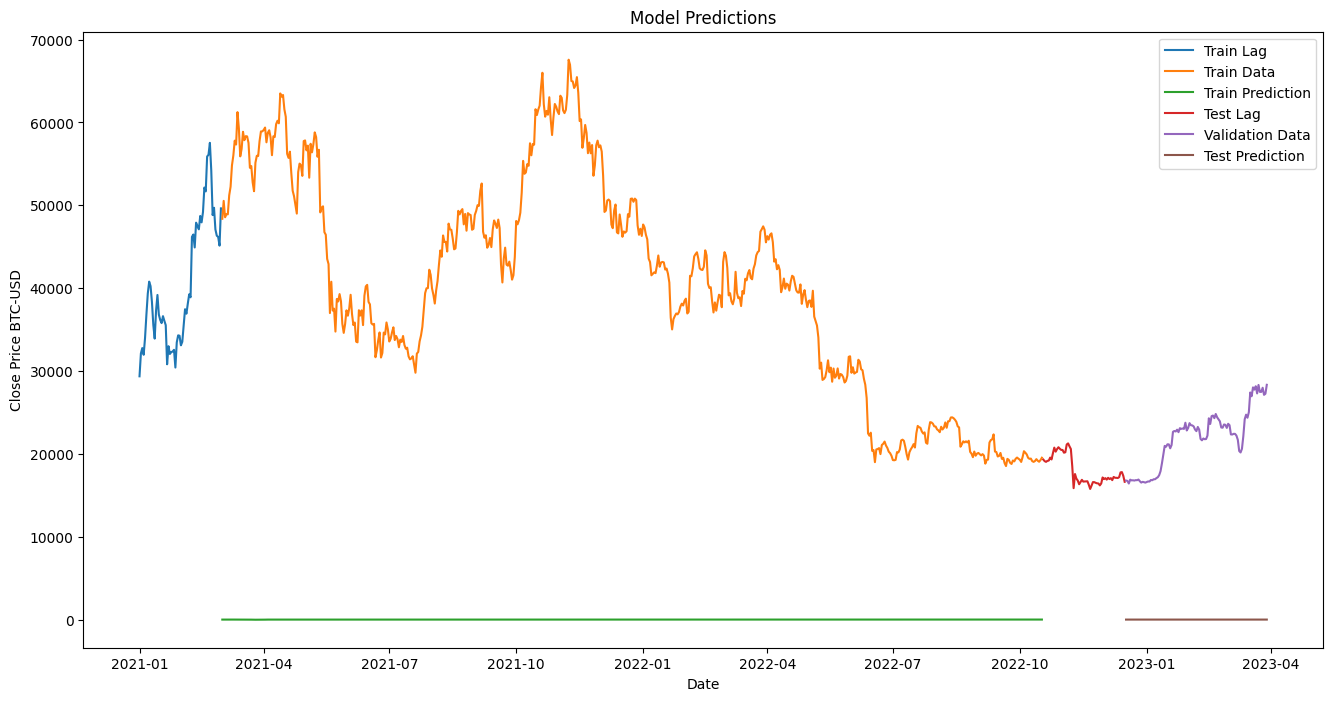

In [28]:
train_lag = df[:60]
train = df[60:training_data_len]
train['Learning'] = train_predictions


test = df[training_data_len:training_data_len+lag]


valid = df[training_data_len+lag:]
valid['Predictions'] = test_predictions

plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price BTC-USD')
plt.plot(train_lag['Close'])
plt.plot(train[['Close','Learning']])
plt.plot(test['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train Lag','Train Data','Train Prediction','Test Lag','Validation Data','Test Prediction'])